In [1]:
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
%matplotlib inline

import MetaTrader5 as mt5 # для работы с торговой платформой

import threading # для многопоточности
import pickle # сохранение объектов

from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn.metrics import make_scorer #создание метрики
from sklearn import model_selection #методы разделения и валидации

from prophet import Prophet
#from neuralprophet import NeuralProphet

from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import optuna # для оптимизации гиперпараметров
import pmdarima as pm # для автоматического подбора гиперпараметров

from statsmodels.tsa.arima.model import ARIMA # для модели ARIMA

import datetime as dt
from datetime import datetime

from tqdm import tqdm  # для отображения прогресса долгих рассчетов
tqdm.pandas()

from IPython.display import clear_output # для очистки вывода
import logging # для логирования
import random # для генерации случайных чисел
import winsound  # пищим динамиком, когда надо
import time

pd.options.mode.chained_assignment = None  # для подавления предупреждений

In [2]:
# зададим переменные
random_state = 42
symbol = "EURUSDrfd"
time_delta = 10 * 60 # 10 минут - время, которое нас интересует в качестве предсказания для пипсовой торговли
pips_delta = 0.00025 # 25 пипсов - минимальное изменение цены, которое нас интересует в качестве предсказания для пипсовой торговли (это мы вычислим позже)

In [3]:
# функция, что-бы попищать динамиком. Полезно, что-бы просигналить, что долгий рассчёт окончен

def beep():
    frequency = 2500  # Set Frequency To 2500 Hertz
    duration = 500  # Set Duration To 1000 ms == 1 second
    winsound.Beep(frequency, duration)
    winsound.Beep(round(frequency/2), duration)
    winsound.Beep(round(frequency/4), duration)
    winsound.Beep(round(frequency/2), duration)
    winsound.Beep(frequency, duration)

# 3. Подготовка даных, исследование

In [77]:
# загрузим данные из файла
ticks_frame_target = pd.read_pickle('pkl/ticks_frame_target.pkl')
ticks_frame = ticks_frame_target.copy()

Фактически, в конечном итоге, как именно модель предсказала нам колебания курса, насколько точно отразила его изменения - нам совершенно неинтересно. Нас интересует конечный результат: сигнал. Вырастет-ли цена? Или упадёт? Или останется той-же с незначительным отклонением?<br>
Поэтому введем, фактически, целевой признак, по которому будем оценивать нашу модель.<br>
Он будет принимать значения -1, 0, 1 (цена упадёт/останется неизменной/цена вырастет)<br>
Для чего мы автоматически разметим данные на каждую секунду.

Для начала посмотрим, а как вообще колеблется цена в выбранном нами временном диапазоне в 10 минут

<i> Осторожно! Этот кусок кода на слабых компьютерах, не смотря на мультитрединг, может выполнятся очень долго </i>

поэтому я сохраню данные и выполню этот кусок кода на мощном сервере

In [78]:
# напишем функцию, которая будет возращать максимальное и минимальное значение цены указанного фрагмента данных
# а так-же время максимального и минимального значения. Это нам пригодится в дальнейшем

def get_min_max(df, start, end):
    # получим фрагмент данных
    df = df[(df.index >= start) & (df.index <= end)]
    # найдем минимальное значение
    min_value = df['bid'].min()
    # найдем максимальное значение
    max_value = df['bid'].max()
    # найдем время минимального значения
    min_time = df[df['bid'] == min_value].index[0]
    # найдем время максимального значения
    max_time = df[df['bid'] == max_value].index[0]
    # вернем результат
    return min_value, max_value, min_time, max_time

# переберем все данные и найдем на сколько изменялась цена за указанный промежуток времени

# рассчёт даже одного месяца будет очень долгим, поэтому разделим данные на несколько частей и посчитаем их разными потоками
# для этого используем библиотеку threading

# зададим количество потоков
threads_count = 32

# зададим количество строк в одном потоке
threads_rows_count = int(len(ticks_frame_target) / threads_count)

# создадим список для хранения потоков
threads = []

# создадим список для хранения результатов
results = []

# создадим функцию, которая будет выполняться в потоке
def thread_function(i, results):
    
    # переберем все значени от i до конца фрагмента данных (с шагом в 600 секунд - это ускорит рассчёт на этом компьютере)
    for j in range(i * threads_rows_count, i * threads_rows_count + threads_rows_count, 600):
        # получим время начала фрагмента данных
        start = ticks_frame_target.index[j]    
        # получим время конца фрагмента данных
        end = start + pd.Timedelta(seconds=time_delta)
        # получим минимальное и максимальное значения цены за фрагмент данных
        min_value, max_value, min_time, max_time = get_min_max(ticks_frame_target, start, end)
        # вычислим разницу между максимальным значением и ценой в начале фрагмента данных
        delta_max = max_value - ticks_frame_target.loc[start, 'bid']
        # вычислим разницу между минимальным значением и ценой в начале фрагмента данных
        delta_min = min_value - ticks_frame_target.loc[start, 'bid']
        # запишем результат в список
        results.append([start, delta_min, delta_max, min_time, max_time])    
  
    
# создадим цикл для создания потоков
for i in range(threads_count):    
    # создадим поток
    x = threading.Thread(target=thread_function, args=(i, results))
    # добавим поток в список
    threads.append(x)
    # запустим поток
    x.start()

# дождемся окончания всех потоков
for i in threads:
    i.join()

# создадим DataFrame для хранения результатов
results_frame = pd.DataFrame(results, columns=['time', 'min_delta', 'max_delta', 'min_time', 'max_time'])

# выведем результаты
results_frame

beep() # Пищим динамиком, что-бы узнать, что рассчёт окончен

In [79]:
# сохраним данные в файл
#results_frame.to_pickle('pkl/results_frame.pkl')

# загрузим данные из файла
results_frame = pd.read_pickle('pkl/results_frame.pkl')

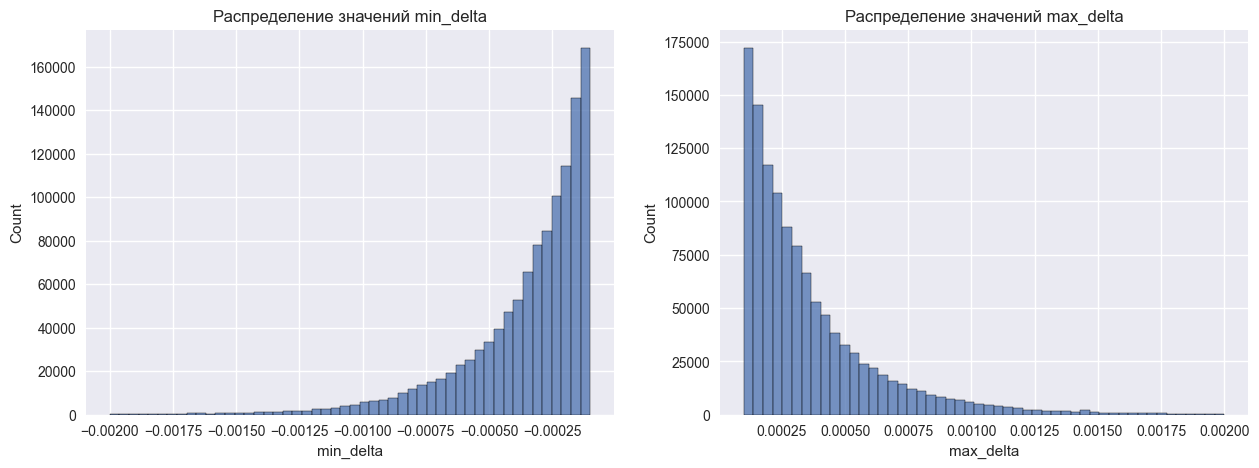

In [106]:
# построим графики распределения изменений цены: значений min_delta и max_delta без значений, которые равны 0 или близки к 0
# за значения близкие к нулю будем считать изменения в 10 пипсов, или 0.0001 (это минимальное изменение цены, которое мы будем учитывать)
# так-же уберем значения свыше 200 пипсов, это редкие события, но они будут сильно портить график

# создадим маску для фильтрации значений
# маска для удаления выходных дней
mask1 = (results_frame['time'].dt.dayofweek < 5)

fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(results_frame['min_delta'][(results_frame['min_delta'] < -0.0001) & (results_frame['min_delta'] > -0.002) & mask1], ax=ax[0], bins=50, kde=False)
sns.histplot(results_frame['max_delta'][(results_frame['max_delta'] < 0.002) & (results_frame['max_delta'] > 0.0001)  & mask1], ax=ax[1], bins=50, kde=False)
ax[0].set_title('Распределение значений min_delta')
ax[1].set_title('Распределение значений max_delta')
plt.show()


<Axes: title={'center': 'Изменение цены за 10 минут'}>

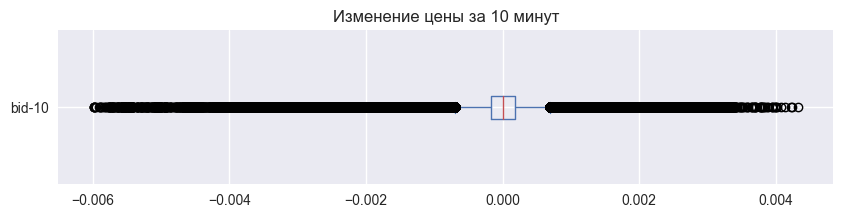

In [119]:
# построим boxplot для значений bid - изменение цены за указанный промежуток времени (10 минут)
# исключим выходные маской
mask2 = pd.to_datetime(ticks_frame_target.index).dayofweek < 5

ticks_frame_target['bid-10'] = ticks_frame_target['bid'].shift(-600) - ticks_frame_target['bid']
ticks_frame_target['bid-10'][mask2].plot(figsize=(10,2), grid=True, kind='box', vert=False, title='Изменение цены за 10 минут')

<Axes: title={'center': 'Изменение цены за 10 минут'}>

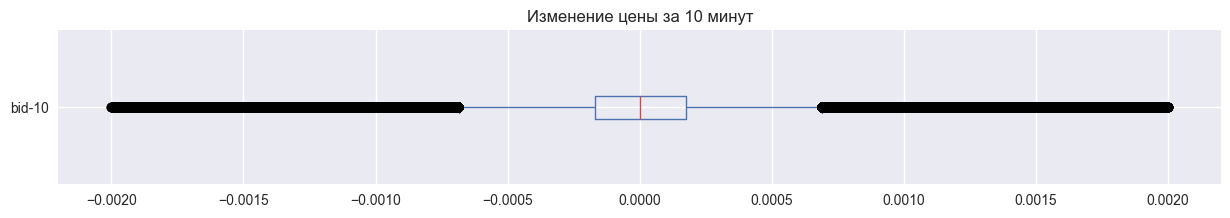

In [120]:
# тоже самое, но без больших выбросов. Более наглядно
ticks_frame_target['bid-10'][mask2 & (abs(ticks_frame_target['bid-10']) <= 0.002)].plot(figsize=(15,2), grid=True, kind='box', vert=False, title='Изменение цены за 10 минут')

Понятно, что нам хочется ловить большое изменение. В 100 пипсов и выше. Но их количество - ничтожно мало. Фактически - выбросы. Я выбрал для дальнейшей работы изменения в 25 пипсов.

In [ ]:
pips_delta = 0.00025 # 25 пипсов

Данный график несколько неточно отображает само распределение. Поскольку мы смотрели на всё изменение цены в течении оговоренного времени (10 минут). Логично, что минимальное изменение (а так-же 0) - будет встречаться значительно чаще. Посмотрим еще на максимального отклонения цены, которая будет за 10 минут. Теперь уже будем смотреть разницу цен Bid-Ask.
заодно посмотрим разницу цен ровно через 10 минут

In [112]:
# Найдем для каждого значения bid, максимальное значение ask, которое будет за 10 минут

def get_max_ask(df, start, end):
    # получим фрагмент данных
    df = df[(df.index >= start) & (df.index <= end)]
    # найдем максимальное значение
    max_value = df['ask'].max()
    # найдем значение ask через 10 минут
    ten_minute_ask = df['ask'][df.index == start + pd.Timedelta(seconds=time_delta)].values[0]
    # найдем время максимального значения
    #max_time = df[df['ask'] == max_value].index[0]
    # вернем результат
    #return max_value, max_time
    return max_value, ten_minute_ask

# переберем все данные и найдем на сколько изменялась цена за указанный промежуток времени. Для ускорения возьмем каждую 600 строку
if not ticks_frame_target.empty:
    for i in tqdm(range(0,len(ticks_frame_target)-time_delta,600)):
        # получим время начала фрагмента данных
        start = ticks_frame_target.index[i]    
        # получим время конца фрагмента данных
        end = start + pd.Timedelta(seconds=time_delta)
        # получим максимальное значение ask за фрагмент данных
        max_value, ten_minute_ask = get_max_ask(ticks_frame_target, start, end)
        # вычислим разницу между максимальным значением и ценой в начале фрагмента данных
        delta_max = max_value - ticks_frame_target.loc[start, 'bid']
        # запишем результат в список
        ticks_frame_target.loc[start, 'delta_bis-ask_max'] = round(delta_max, 5)
        ticks_frame_target.loc[start, '10_minute_diff'] = round (ticks_frame_target.loc[start, 'bid'] - ten_minute_ask, 5)
        # запишем время максимального значения
        #ticks_frame_target.loc[start, 'max_time'] = max_time

beep() # Пищим динамиком, что-бы узнать, что рассчёт окончен

100%|██████████| 4145/4145 [01:17<00:00, 53.72it/s]


In [113]:
ticks_frame_target[::600]['10_minute_diff'].value_counts()

10_minute_diff
-0.00014    1248
-0.00010      72
-0.00021      65
-0.00007      52
-0.00015      52
            ... 
 0.00400       1
-0.00118       1
-0.00114       1
 0.00081       1
-0.00109       1
Name: count, Length: 251, dtype: int64

Очень много значений в -14 пипсов. Это логично. Это спред. Так-же большое влияние оказывает наличие в данных выходных дней, в которых цена статична. 

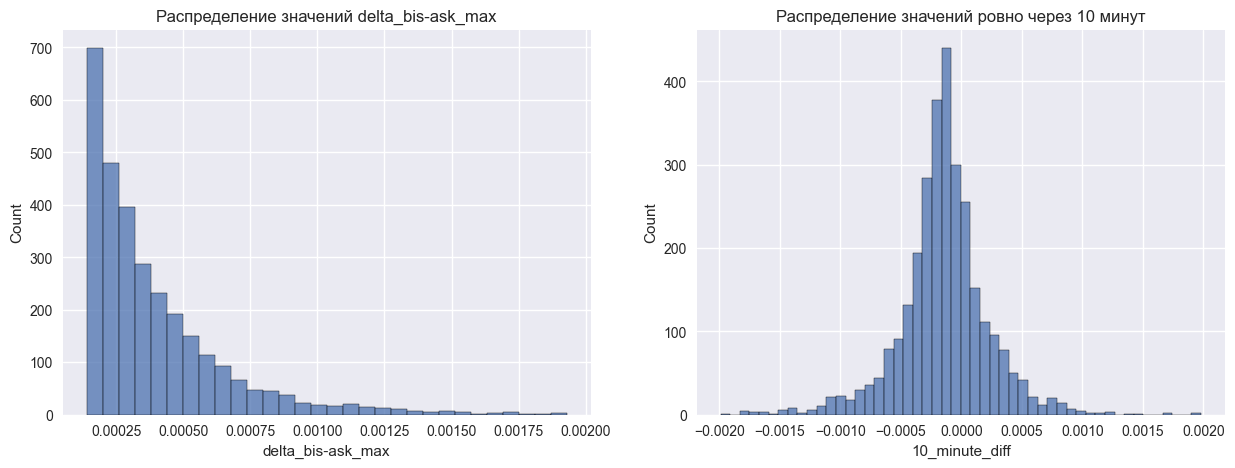

In [121]:
# построим график распределения изменений цены: значений delta_bis-ask_max и значений ровно через 10 минут. Уберем значение спреда, которое равно 14 пипсов, уберем выходные дни

fig, ax = plt.subplots(1, 2, figsize=(15,5))
sns.histplot(ticks_frame_target[::600]['delta_bis-ask_max'][(ticks_frame_target['delta_bis-ask_max'] < 0.002) & mask2], ax=ax[0], bins=30)
sns.histplot(ticks_frame_target[::600]['10_minute_diff'][(abs(ticks_frame_target['10_minute_diff']) < 0.002) & mask2], ax=ax[1], bins=50)
ax[0].set_title('Распределение значений delta_bis-ask_max')
ax[1].set_title('Распределение значений ровно через 10 минут')
plt.show()


<Axes: title={'center': 'Изменение цены за 10 минут'}>

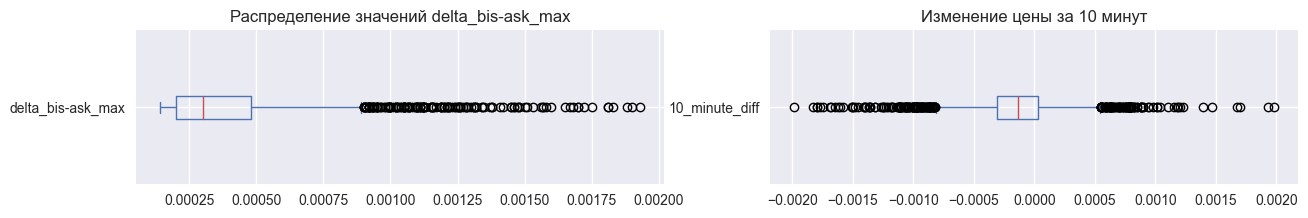

In [130]:
# тоже, на на boxplot
fig, ax = plt.subplots(1, 2, figsize=(15,5))
ticks_frame_target[::600]['delta_bis-ask_max'][(ticks_frame_target['delta_bis-ask_max'] < 0.002) & mask2].plot(figsize=(15,2), grid=True, kind='box', vert=False, title='Распределение значений delta_bis-ask_max', ax=ax[0])
ticks_frame_target[::600]['10_minute_diff'][(abs(ticks_frame_target['10_minute_diff']) < 0.002) & mask2].plot(figsize=(15,2), grid=True, kind='box', vert=False, title='Изменение цены за 10 минут', ax=ax[1])


Логично, что распределение итоговой цены сдвинуто влево с пиком (удалён с графика) в размере спреда. В целом, распределение нормальное. Снова убеждаюсь, что выбор разницы курса в 25 пипсов был оптимален для построения модели. Брать меньше - нет смысла. Будет слишком близко к спрэду.

## 3-а. Разметка данных.

Пришла пора разметить данные. Получить целевой признак по которому будем оценивать нашу модель. А имеено - если цена Bid-Ask измениться за 10 минут больше, чем на 25 пипсов - даём +1 или -1 сигнал, в зависимости от направления цены.

In [ ]:
pips_delta = 0.00025 # 25 пипсов

In [ ]:
# напишем функцию, которая принимает на вход фрагмент датафрейма, и на выходе выдаёт 1, если в этот момент была-бы профитна покупка, и -1, если была-бы профитна продажа.
# если бы ни одна из сделок не была бы профитна, то функция вернёт 0
# покупаем мы на старте по ask, а продаем по bid
# продаём мы на старте по bid, а покупаем по ask

def get_profit(df):
    # получим минимальное значение цены за фрагмент данных за которое можно было бы купить
    min_value = df['ask'].min()
    # получим максимальное значение цены за фрагмент данных за которое можно было бы продать
    max_value = df['bid'].max()
    # получим цену покупки в начале фрагмента данных
    start_value_bid = df['bid'].iloc[0]
    # получим цену продажи в начале фрагмента данных
    start_value_ask = df['ask'].iloc[0]
    
    # вычислим разницу между максимальным значением и ценой в начале фрагмента данных
    delta_buy = max_value - start_value_ask
    # вычислим разницу между минимальным значением и ценой в начале фрагмента данных
    delta_sell = start_value_bid - min_value
    
    # если разница между максимальным значением и ценой в начале фрагмента данных больше 25 пипсов, то это сигнал на покупку
    if delta_buy > pips_delta:
        return 1
    # если разница между минимальным значением и ценой в начале фрагмента данных меньше -25 пипсов, то это сигнал на продажу
    elif delta_sell > pips_delta:
        return -1
    # если ни одно из условий не выполнено, то сигнала нет
    return 0

In [ ]:
ticks_frame_target = ticks_frame.copy()

Это так-же очень долгие вычисления (несколько часов). Их мы будем производить на многопроцессорном сервере, а сюда загрузим итоговый результат.
Можно считать и здесь, но на моём компе это займёт больше суток.

In [ ]:
# сохраним данные в файл
ticks_frame_target.to_pickle('pkl/ticks_frame_target.pkl')

# загрузим данные из файла
#ticks_frame_target = pd.read_pickle('pkl/ticks_frame_target.pkl')

In [ ]:
# переберем все данные и создадим колонку с сигналами
# для ускорения используем threading

# создадим колонку с сигналами
ticks_frame_target['signal'] = 99 # 99 - это сигнал, что сигнала нет, в целях отладки

# зададим количество потоков (Локально придётся считать в один поток, что-бы не менять код. Потому-что тут мы считаем с шагом.)
threads_count = 1

# зададим количество строк в одном потоке
threads_rows_count = int(len(ticks_frame_target) / threads_count)

# создадим список для хранения потоков
threads = []

# создадим список для хранения результатов
results = []

# создадим функцию, которая будет выполняться в потоке
def thread_function(j, results):
    for i in range(j * threads_rows_count, j * threads_rows_count + threads_rows_count, 1000): # шаг 1000 секунд
        # получим время начала фрагмента данных
        start = ticks_frame_target.index[i]    
        # получим время конца фрагмента данных
        end = start + pd.Timedelta(seconds=time_delta)
        # получим фрагмент данных
        df = ticks_frame_target[(ticks_frame_target.index >= start) & (ticks_frame_target.index <= end)]
        # получим сигнал
        signal = get_profit(df)
        # запишем сигнал в колонку
        ticks_frame_target.loc[start, 'signal'] = signal

# создадим цикл для создания потоков
for j in range(threads_count):
    # создадим поток
    x = threading.Thread(target=thread_function, args=(j, results))
    # добавим поток в список
    threads.append(x)
    # запустим поток
    x.start()

# дождемся окончания всех потоков
for i in threads:
    i.join()
    
beep() # Пищим динамиком, что-бы узнать, что рассчёт окончен

In [ ]:
# промежуточный результат каждой 100 строки
ticks_frame_target[::1000]['signal'].value_counts(normalize=True) * 100

signal
 0    71.141479
 1    15.112540
-1    13.745981
Name: proportion, dtype: float64

Всё верно, можно запускать многочасовой обсчет на сервере

13-15% целевого признака в общей массе данных - вполне устраивает.

In [ ]:
# загрузим полные данные из файла с сервера
ticks_frame_target = pd.read_pickle('pkl/ticks_frame_target_solved.pkl')

In [ ]:
# полный результат
ticks_frame_target['signal'].value_counts(normalize=False)

signal
 0    1794109
 1     363297
-1     330193
Name: count, dtype: int64

Посмотрим, как распределен у нас целевой признак на временной шкале

<Axes: title={'center': 'Сигналы на покупку и продажу'}, xlabel='time'>

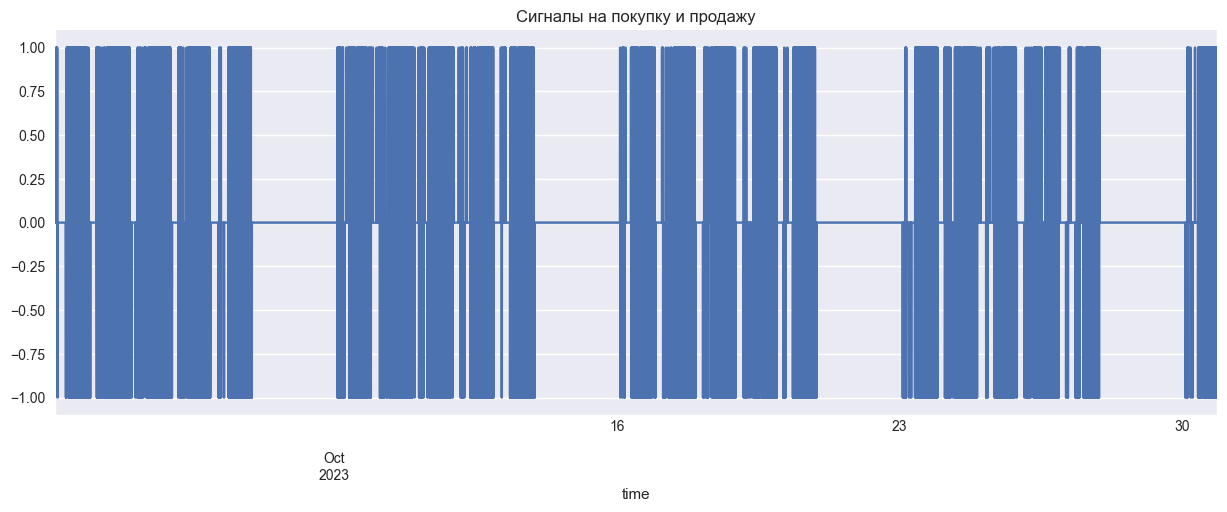

In [ ]:
# построим временной график сигналов
ticks_frame_target['signal'].plot(figsize=(15,5), grid=True, title='Сигналы на покупку и продажу')


<Axes: title={'center': 'Сигналы на покупку и продажу за неделю'}, xlabel='time'>

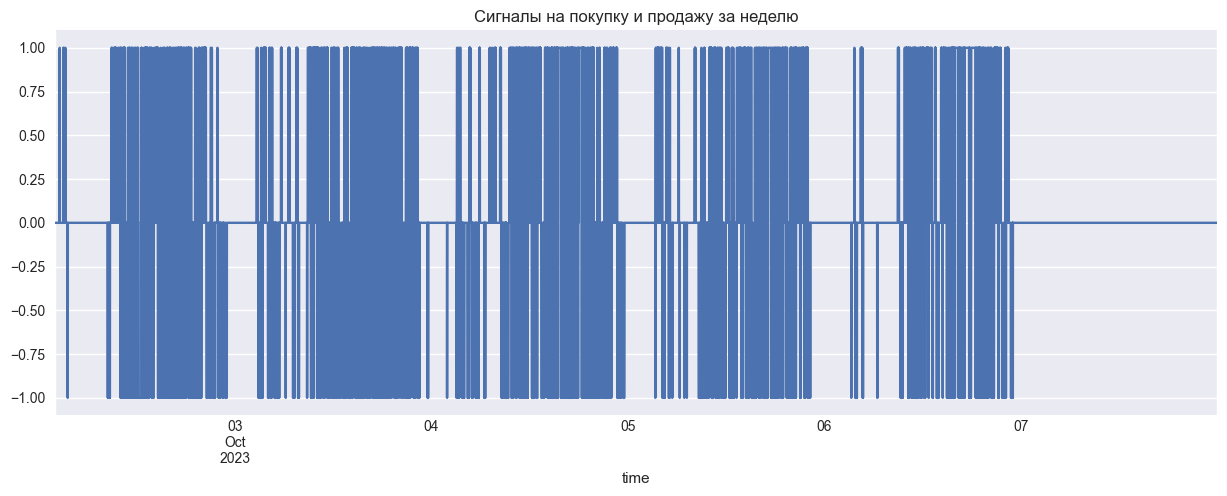

In [ ]:
# тоже самое, но за одну неделю
ticks_frame_target['signal'].loc['2023-10-01':'2023-10-07'].plot(figsize=(15,5), grid=True, title='Сигналы на покупку и продажу за неделю')

<Axes: title={'center': 'Сигналы на покупку и продажу за день'}, xlabel='time'>

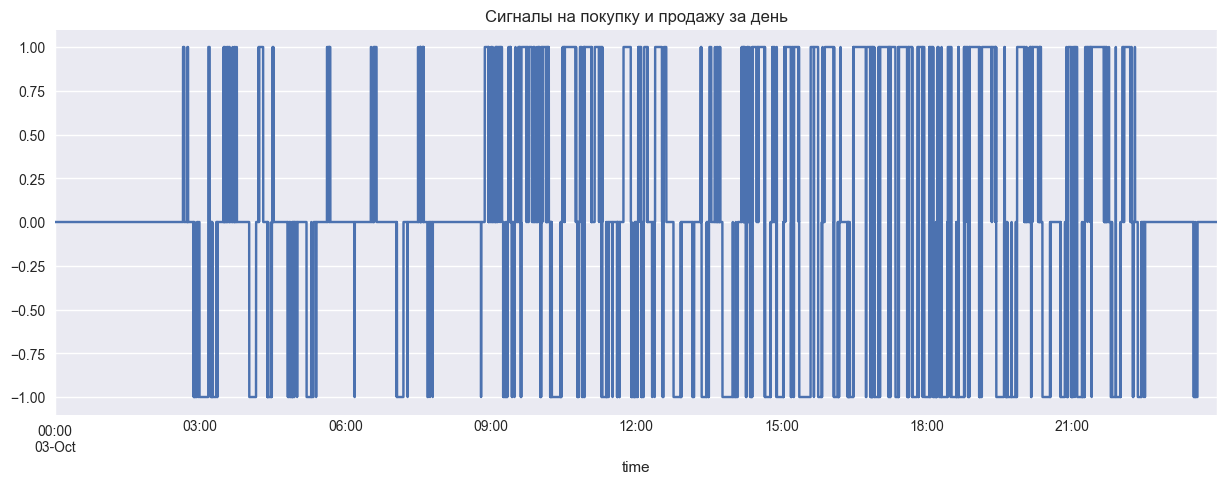

In [ ]:
# тоже самое, но за один день
ticks_frame_target['signal'].loc['2023-10-03':'2023-10-03'].plot(figsize=(15,5), grid=True, title='Сигналы на покупку и продажу за день')

Что-ж, сигналов много, довольно часто, они относительно равномерно распределены. Наблюдается очевидные "провалы" в нерабочие дни, и в раннее время и ночью.

Итак. У нас есть целевой признак, который должен выдавать наш алгоритм. И он имеет всего 3 значения: -1, 0 и 1. Может с этой задачей может справится банальная логистическая регрессия? Или, скажем, случайный лес? Перед тем, как приступать к полноценной работе над временным рядом, проверим более простое решение. Заодно это станет нашим первым baseline-ом.